In [ ]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
pip install rasterio

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
from pathlib import Path

from tqdm import tqdm

import sys, os, random, time, json
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch import FPN
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch import MAnet
from segmentation_models_pytorch import Linknet
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold

%matplotlib inline

In [3]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [4]:
!mkdir -p /home/jupyter/data/
DATA_PATH = Path('/home/jupyter/data_2/')
assert DATA_PATH.exists()

In [5]:
REPORT_PATH = Path('/home/jupyter/reports')
if not REPORT_PATH.exists():
    os.makedirs(REPORT_PATH)
assert REPORT_PATH.exists()

In [6]:
!ls {REPORT_PATH}

37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_0
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_1
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_2
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_3
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_0
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_1
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_2
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_3
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_0
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_1
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_2
39_pytorch_fpn_efficientnet_b7_15

In [7]:
ARCH = 'unet' # fpn, manet, linknet
EXPERIMENT_NAME = f'40_pytorch_{ARCH}_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data'

WINDOW = 1536 # tile size
MIN_OVERLAP = 54
NEW_SIZE = 768 # size after re-size which are fed to the model
THRESHOLD = 0
CONTENT_THRESHOLD = 0.001

FOLDS = 4

BATCH_SIZE = 6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ENCODER_NAME = 'efficientnet-b7'

LR = 1e-3
WD = 1e-3
LABEL_SMOOTH = 0.01
GRAD_ACCU_STEPS = 1
BEST_MODEL = f'best_model_{ARCH}_efficientnetb7_1536_768_double_shift_{ENCODER_NAME}.pth'

RESET_IMAGES = False
ENCODER_WEIGHTS = 'imagenet'

In [8]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [9]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [10]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

In [11]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [12]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c  56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f  113277795 21 113315936 53 113354083 87 1133922...
54f2eec69  124967057 36 124997425 109 125027828 147 12505...
4ef6695ce  137041956 58 137081912 65 137121869 72 1371618...
26dc41664  245832956 28 245869925 2 245871115 33 24590808...
c68fe75ea  21256809 3 21283644 10 21310479 17 21337315 22...
afa5e8098  65837968 7 65874765 11 65874827 12 65911562 15...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [13]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [14]:

# Used to filter tiles with enough color information in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = CONTENT_THRESHOLD, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [15]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6130, 0.4126, 0.6595], [0.1417, 0.2045, 0.1237])

def read_from_slice(dataset, layers, x1, x2, y1, y2):
    if dataset.count == 3:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
    else:
        image = np.zeros((WINDOW, WINDOW, 3), dtype=np.uint8)
        for fl in range(3):
            image[:,:,fl] = layers[fl].read(window=Window.from_slices((x1,x2),(y1,y2)))
    return image.astype(np.uint8)

def extract_layers(dataset, filepath):
    layers = None
    if dataset.count != 3:
        layers = [rasterio.open(subd) for subd in dataset.subdatasets]
    return layers

In [16]:
if RESET_IMAGES:
    reset_mask_path()
    !mkdir {MASK_PATH}

In [17]:
class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, valid_transform=None, mode='train', window=WINDOW, overlap=MIN_OVERLAP, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.valid_transform, self.threshold = overlap, window, transform, valid_transform, threshold
        self.mode = mode
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
    def __copy__(self):
        new_ds = type(self)(
            self.path,
            self.transform,
            valid_transform=self.valid_transform,
            mode=self.mode,
            window=self.window,
            overlap=self.overlap,
            threshold=self.threshold
        )
        new_ds.masks = self.masks
        new_ds.files = self.files
        new_ds.slices = self.slices
        new_ds.skipped = self.skipped
        return new_ds
    
    def build_masks(self):
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            with rasterio.open(filepath) as dataset:
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset.shape))
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        slices_path = MASK_PATH/f'slices.pkl'
        files_path = MASK_PATH/f'files.pkl'
        masks_path = MASK_PATH/f'masks.pkl'
        if not slices_path.exists():
            for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
                filepath = self.path/'train'/f'{filename}.tiff'
                assert filepath.exists()
                self.files.append(filepath)
                with rasterio.open(filepath) as dataset:
                    self.build_slice(dataset, filename, i)
                print(f'Finished {filename}')
            with open(slices_path, "wb") as filehandler:
                pickle.dump(self.slices, filehandler)
            with open(files_path, "wb") as filehandler:
                pickle.dump(self.files, filehandler)
            
        else:
            print('Reading cached slices, files and masks')
            with open(slices_path,'rb') as file:
                self.slices = pickle.load(file)
            with open(files_path,'rb') as file:
                self.files = pickle.load(file)
        self.build_masks()
                
    def build_slice(self, dataset, filename, i):
        dataset_shape = dataset.shape
        self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
        slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)

        # Shifting slices to the right and bottom and adding to the original slices
        slices_copy = slices.copy()
        slices_copy_y = slices.copy()
#         # horizontal
        slices_copy[:,(0,1)] += WINDOW // 2 # shift
        slices = np.concatenate ([slices, slices_copy])
#         # vertical
        slices_copy_y[:,(2,3)] += WINDOW // 2
        slices = np.concatenate ([slices, slices_copy_y])
        slices = slices[~(slices[:,1] > dataset_shape[0]),:] # filter those outside of the screen
        slices = slices[~(slices[:,3] > dataset_shape[1]),:] # filter those outside of the screen
        
        layers = extract_layers(dataset, filename)
        
        # Only including slices above a specific threshold
        # Note: we are potentially throwing away some data here
        for slc in slices:
            x1, x2, y1, y2 = slc
            image = read_from_slice(dataset, layers, x1, x2 , y1, y2)
#             contains_info = is_tile_contains_info(image)
#             if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
            if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                self.slices.append([i,x1,x2,y1,y2])
            else:
                self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask) if self.mode == 'train' else self.valid_transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        mask_torch = torch.from_numpy(mask).to(torch.float16)
        return image, mask_torch
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                layers = extract_layers(dataset, filename)
                image = read_from_slice(dataset, layers, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped} mode: {self.mode}'

In [18]:
def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.4),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.4),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=3),
            A.RandomBrightnessContrast(),            
        ], p=0.5)
    ], p=1.0)
    
    valid_transform = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90()
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm, valid_transform=valid_transform)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  7%|▋         | 1/15 [01:30<21:00, 90.04s/it]

Finished 2f6ecfcdf


 13%|█▎        | 2/15 [04:12<28:44, 132.69s/it]

Finished 8242609fa


 20%|██        | 3/15 [04:23<15:22, 76.88s/it] 

Finished aaa6a05cc


 27%|██▋       | 4/15 [07:37<22:38, 123.47s/it]

Finished cb2d976f4


 33%|███▎      | 5/15 [10:08<22:10, 133.07s/it]

Finished b9a3865fc


 40%|████      | 6/15 [10:27<14:10, 94.54s/it] 

Finished b2dc8411c


 47%|████▋     | 7/15 [12:08<12:51, 96.48s/it]

Finished 0486052bb


 53%|█████▎    | 8/15 [12:13<07:52, 67.48s/it]

Finished e79de561c


 60%|██████    | 9/15 [13:34<07:09, 71.65s/it]

Finished 095bf7a1f


 67%|██████▋   | 10/15 [13:52<04:36, 55.22s/it]

Finished 54f2eec69


 73%|███████▎  | 11/15 [15:50<04:56, 74.22s/it]

Finished 4ef6695ce


 80%|████████  | 12/15 [17:15<03:52, 77.48s/it]

Finished 26dc41664


 87%|████████▋ | 13/15 [18:43<02:41, 80.93s/it]

Finished c68fe75ea


 93%|█████████▎| 14/15 [19:02<01:02, 62.09s/it]

Finished afa5e8098


  0%|          | 0/15 [00:00<?, ?it/s]

Finished 1e2425f28


100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


In [19]:
ds

total: 7207, skipped: 16227 mode: train

In [20]:
# with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
#     img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
#     img = np.moveaxis(img, 0, -1)
#     print(img.shape)
#     crs = raster.crs

# plt.figure(figsize = (20,20))
# plt.imshow(img)
# plt.show()


In [21]:
# slices = make_grid(raster.shape, window = WINDOW, min_overlap = MIN_OVERLAP)
# slices.shape

In [22]:
# slices_copy_y = slices.copy()
# slices_copy_y[:,(2,3)] += WINDOW // 2
# slices_copy_y = slices_copy_y[~(slices_copy[:,3] > raster.shape[1]),:]
# slices = np.concatenate ([slices, slices_copy_y])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Writing to /home/jupyter/ds_cache/image_0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


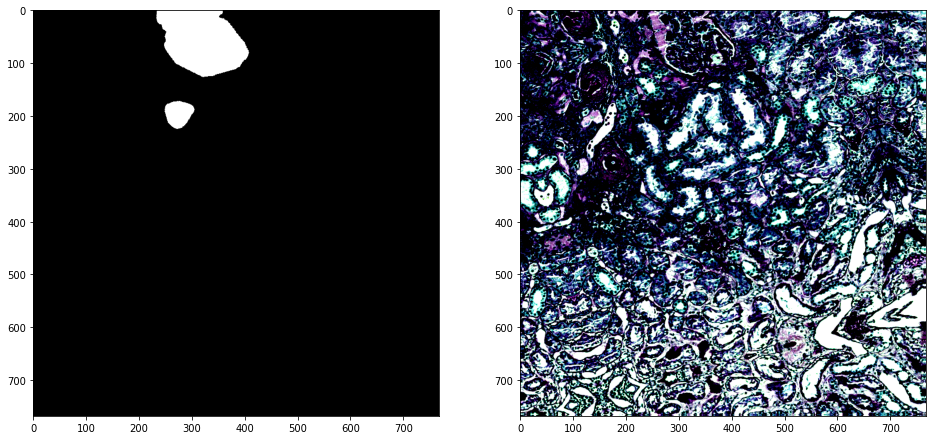

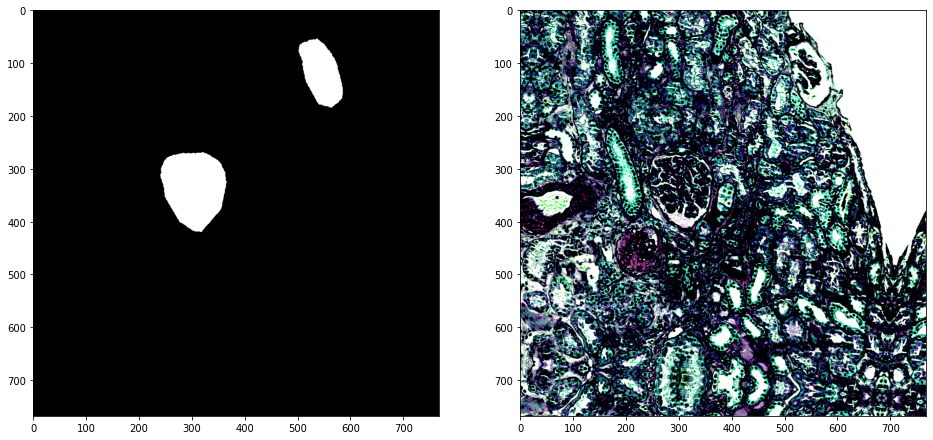

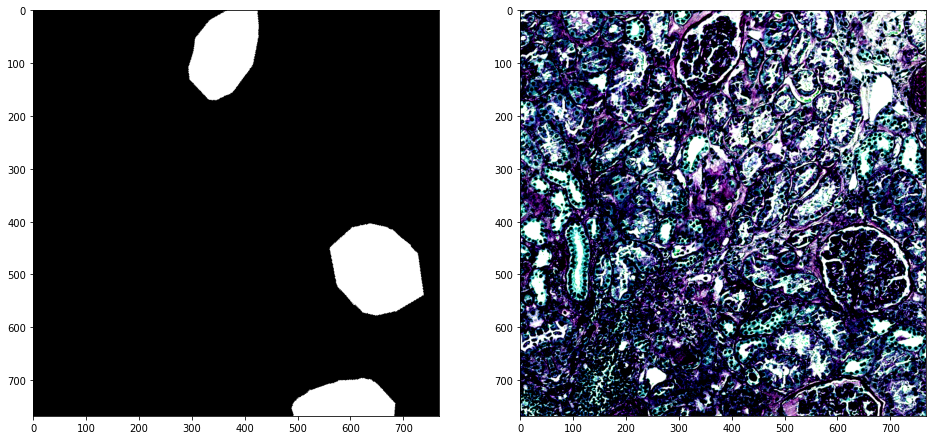

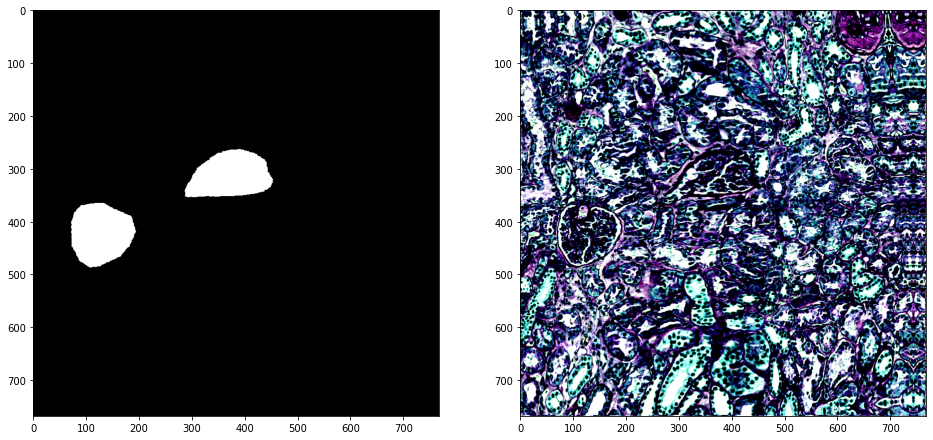

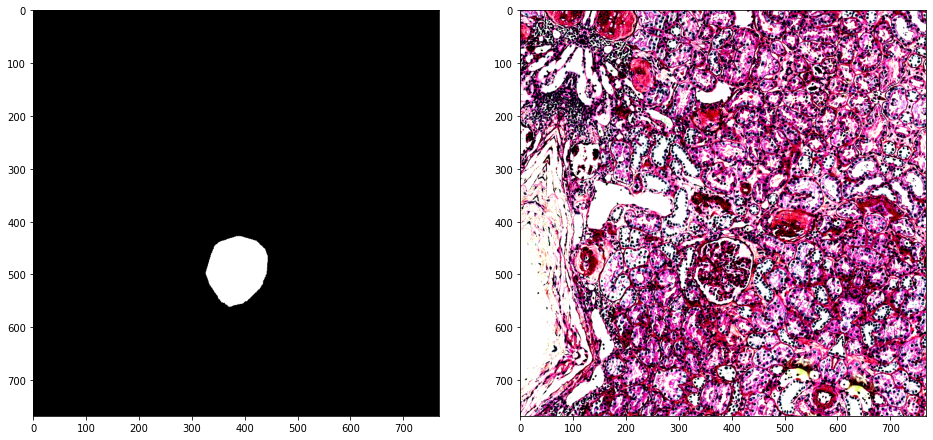

In [23]:
def display_mask_img(idx):
    image, mask = ds[idx]
    mask = mask.to(torch.uint8)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

for i in range(5):
    display_mask_img(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


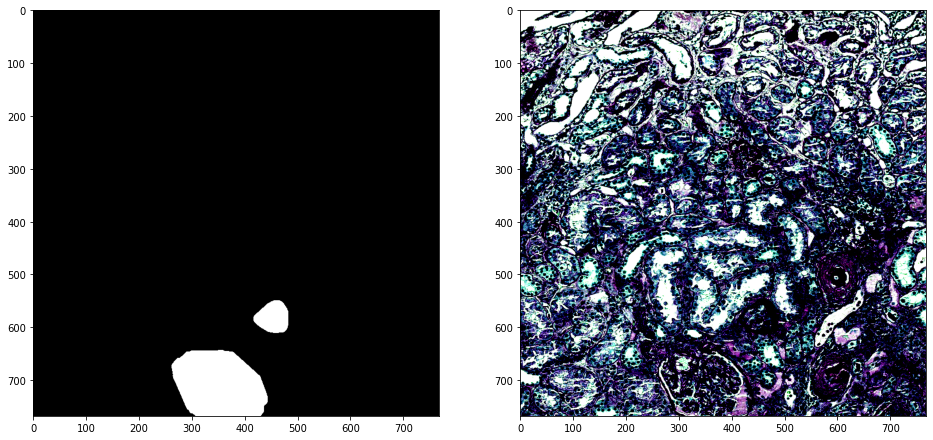

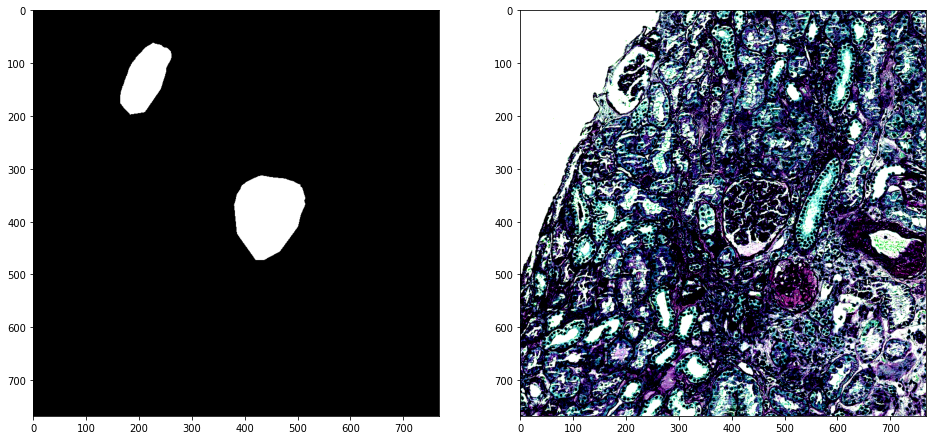

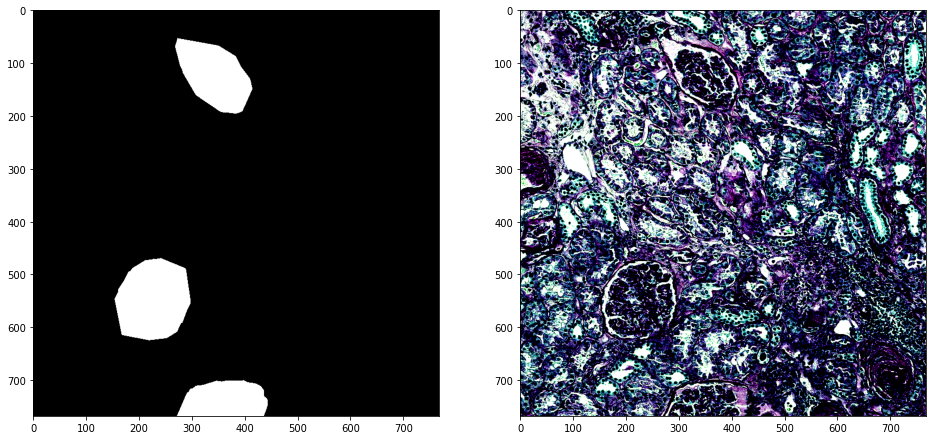

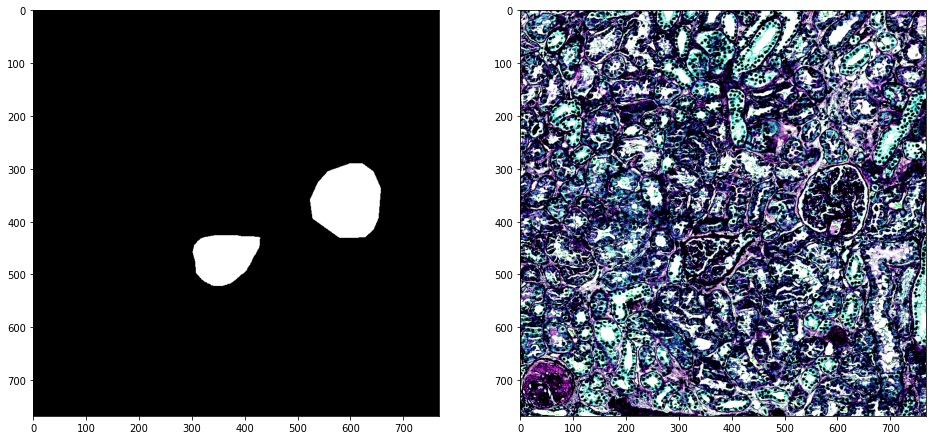

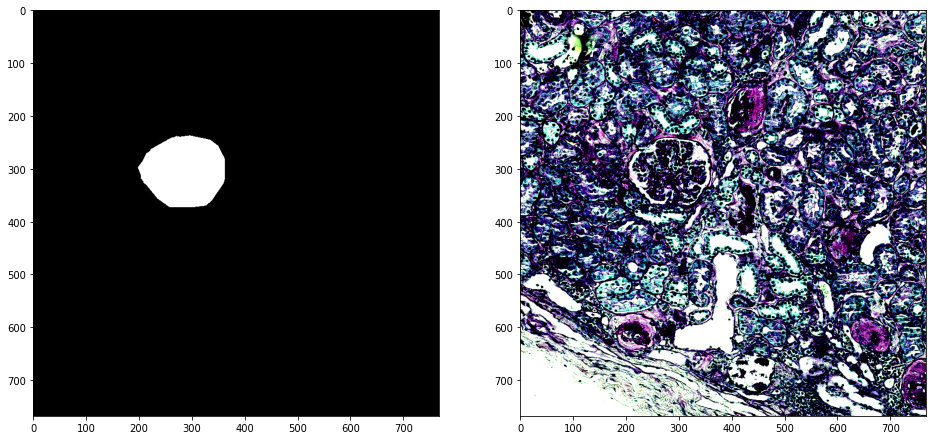

In [24]:
ds.mode = 'valid'

for i in range(5):
    display_mask_img(i)

In [25]:
ds.mode = 'train'

In [26]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0].numpy().astype('uint8')) # compile function with numba

In [27]:
image.shape

torch.Size([3, 768, 768])

#### Split

In [28]:
# Images and its corresponding masks are saved with the same filename.
groups = [ds.slices[i][0] for i in range(len(ds))]

In [29]:
group_kfold = GroupKFold(n_splits = FOLDS)

#### Data loaders

In [30]:
import copy

def create_subset(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    val_ds = copy.copy(ds)
    val_ds.mode = 'valid'
    valid_ds = D.Subset(val_ds, valid_idx)
    print(val_ds)
    return train_ds, valid_ds

In [31]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds, valid_ds = create_subset(ds, train_idx, valid_idx)

    num_workers = 0
    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    return train_dl, valid_dl

### Model

In [80]:
class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        args = {
            'encoder_name': ENCODER_NAME, 
            'encoder_weights': ENCODER_WEIGHTS,
            'classes': 1,
            'activation': None,
            'aux_params': None
        }
        if ARCH == 'unet':
            self.model = Unet(**args)
        elif ARCH == 'fpn':
            self.model = FPN(**args)
        elif ARCH == 'manet':
            self.model = MAnet(**args)
        elif ARCH == 'linknet':
            self.model = Linknet(**args)
        
    def forward(self, images):
        return self.model(images)

In [81]:
def get_model():
    return HuBMAPModel()

### Training

In [82]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [83]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [84]:
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [85]:
LOSS_ALPHA = 0.4

def loss_fn(y_pred, y_true):
    return LOSS_ALPHA * dice_loss(y_pred.sigmoid(), y_true) + (1 - LOSS_ALPHA) * bce_fn(y_pred, y_true)

In [86]:
# jaccard_loss = smp.utils.losses.JaccardLoss()

# def loss_fn(y_pred, y_true):
#     return jaccard_loss(y_pred.sigmoid(), y_true)

In [87]:
def dice_metric(y_pred, y, epsilon = 1e-7):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [88]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)
dice_metric_2 = smp.utils.metrics.Fscore()

In [89]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
# def smooth_mask(mask, alpha = 0.9):
#     zeros_mask = (mask == 0).to(torch.float16) * (1 - alpha)
#     mask = mask * alpha
#     return mask + zeros_mask

def smooth_mask_2(mask, alpha = LABEL_SMOOTH):
    return (1 - alpha) * mask + alpha / 2

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu", grad_accu_steps=GRAD_ACCU_STEPS):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader, position=0, leave=True)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    scale = None
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        target = smooth_mask_2(target)
        
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target) / grad_accu_steps
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step + 1) % grad_accu_steps == 0:
            scaler.step(optim)
            scale = scaler.get_scale()
            scaler.update()
            optim.zero_grad()
        
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        loss_val = loss.item() * grad_accu_steps
        train_loss.append(loss_val)
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss_val))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [90]:
all_metrics = [dice_metric, dice_metric_2, iou_metric]

def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    metric_list = [[] for _ in all_metrics]

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            for ml, m in zip(metric_list, all_metrics):
                ml.append(m(output, target).item())
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metric_mean = np.array(metric_list[0]).mean()
    dice_metric_mean_2 = np.array(metric_list[1]).mean()
    iou_metric_mean = np.array(metric_list[2]).mean()
    return valid_loss, dice_metric_mean, avg_loss, iou_metric_mean, dice_metric_mean_2

In [91]:
def train(fold, epochs, train_dl, valid_dl, optimizer, scheduler, patience = 6):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []
    early_stop_counter = 0
    messages = []

    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        valid_loss, dice_metric_mean, avg_loss, iou_metric_mean, dice_metric_mean_2 = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(dice_metric_mean)
        if best_metric < dice_metric_mean:
            best_metric = dice_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}, {dice_metric_mean_2}) iou metric ({iou_metric_mean}).')
        messages.append({
            'fold': fold,
            'epoch': epoch,
            'best_loss': best_loss,
            'dice_metric_mean': dice_metric_mean,
            'dice_coeff_mean': dice_metric_mean_2,
            'iou_metric_mean': iou_metric_mean
        })
        with open(REPORT_PATH/f'{EXPERIMENT_NAME}_fold_{fold}', 'w') as outfile:
            json.dump(messages, outfile)
        if early_stop_counter >= patience:
            print('Stopping early')
            break
    
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [92]:
fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(ds.slices, 
                                                        groups = groups)), total=FOLDS)]

100%|██████████| 4/4 [00:00<00:00, 867.35it/s]


In [93]:
# !rm sample_weights_model_efficientnet_b7.pth

In [94]:
EPOCHS = 15
PATIENCE = 5

In [95]:
def train_split(fold_info, fold):
    global model
    
    print(f'Processing fold {fold}')
    model = get_model()
    model.to(DEVICE)
    train_idx, valid_idx = fold_info[fold]
    print(f'Proportions valid / train: {len(valid_idx) / len(train_idx)}')
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(fold, EPOCHS, train_dl, valid_dl, optimizer, scheduler, patience = PATIENCE)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [96]:
# from fastai.data.core import DataLoaders

# train_idx, valid_idx = fold_info[0]
# train_ds, valid_ds = create_subset(ds, train_idx, valid_idx)

# dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=BATCH_SIZE, num_workers=0)
# assert(dls.bs == BATCH_SIZE)

In [97]:
# model = get_model()
# metrics = [dice_metric, dice_metric_2, iou_metric]
# criterion = loss_fn

In [98]:
# from fastai.vision.all import Learner
# from fastai.callback.fp16 import *

# learn = Learner(dls, model, loss_func=criterion, lr=LR, metrics=metrics, cbs=[MixedPrecision])
# learn = learn.to_fp16()

In [99]:
# %%time

# learn.fit_one_cycle(EPOCHS)

In [100]:
# train_idx, valid_idx = fold_info[0]
# train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
# for image, target in tqdm(train_dl):
#     pass
# #     assert image.shape[0] > 1
# for image, target in tqdm(valid_dl):
#     pass
# #     assert image.shape[0] > 1

In [101]:
def train_split_and_move(fold_info, fold):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(fold_info, fold)
    !mv {BEST_MODEL} {fold}_{BEST_MODEL}
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()

Processing fold 0


  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.32627898417372103
Reading cached slices, files and masks


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  0%|          | 0/906 [00:00<?, ?it/s]

total: 7207, skipped: 16227 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.8976:   0%|          | 4/906 [00:11<43:54,  2.92s/it]

Writing to /home/jupyter/ds_cache/image_3200


loss - 0.8588:   4%|▍         | 36/906 [01:35<42:13,  2.91s/it]

Writing to /home/jupyter/ds_cache/image_5900


loss - 0.8636:   4%|▍         | 40/906 [01:46<40:59,  2.84s/it]

Writing to /home/jupyter/ds_cache/image_1000


loss - 0.8533:   5%|▍         | 42/906 [01:53<44:13,  3.07s/it]

Writing to /home/jupyter/ds_cache/image_2800


loss - 0.8211:   8%|▊         | 73/906 [03:19<31:19,  2.26s/it]

Writing to /home/jupyter/ds_cache/image_500


loss - 0.8222:  10%|█         | 95/906 [04:20<42:28,  3.14s/it]

Writing to /home/jupyter/ds_cache/image_700


loss - 0.7923:  15%|█▍        | 134/906 [05:59<30:24,  2.36s/it]

Writing to /home/jupyter/ds_cache/image_400


loss - 0.7715:  15%|█▌        | 139/906 [06:12<33:11,  2.60s/it]

Writing to /home/jupyter/ds_cache/image_1700


loss - 0.7570:  16%|█▋        | 148/906 [06:40<36:46,  2.91s/it]

Writing to /home/jupyter/ds_cache/image_2900


loss - 0.7461:  17%|█▋        | 158/906 [07:08<32:55,  2.64s/it]

Writing to /home/jupyter/ds_cache/image_5800


loss - 0.7805:  18%|█▊        | 162/906 [07:17<28:40,  2.31s/it]

Writing to /home/jupyter/ds_cache/image_1300


loss - 0.7368:  19%|█▉        | 173/906 [07:44<32:22,  2.65s/it]

Writing to /home/jupyter/ds_cache/image_3700


loss - 0.7355:  21%|██        | 189/906 [08:27<29:55,  2.50s/it]

Writing to /home/jupyter/ds_cache/image_300


loss - 0.7180:  21%|██        | 192/906 [08:35<30:02,  2.52s/it]

Writing to /home/jupyter/ds_cache/image_1400


loss - 0.7397:  22%|██▏       | 197/906 [08:48<29:31,  2.50s/it]

Writing to /home/jupyter/ds_cache/image_6300


loss - 0.7058:  23%|██▎       | 205/906 [09:09<30:27,  2.61s/it]

Writing to /home/jupyter/ds_cache/image_3100


loss - 0.6874:  26%|██▌       | 232/906 [10:27<31:52,  2.84s/it]

Writing to /home/jupyter/ds_cache/image_600


loss - 0.6907:  28%|██▊       | 254/906 [11:27<27:59,  2.58s/it]

Writing to /home/jupyter/ds_cache/image_2100


loss - 0.6523:  29%|██▉       | 263/906 [11:54<31:52,  2.97s/it]

Writing to /home/jupyter/ds_cache/image_5600


loss - 0.6333:  35%|███▍      | 315/906 [14:17<25:53,  2.63s/it]

Writing to /home/jupyter/ds_cache/image_1200


loss - 0.6203:  36%|███▋      | 329/906 [14:57<27:37,  2.87s/it]

Writing to /home/jupyter/ds_cache/image_3800


loss - 0.6069:  38%|███▊      | 340/906 [15:29<31:10,  3.30s/it]

Writing to /home/jupyter/ds_cache/image_2200


loss - 0.6073:  39%|███▉      | 352/906 [15:59<23:09,  2.51s/it]

Writing to /home/jupyter/ds_cache/image_1500


loss - 0.5806:  41%|████      | 370/906 [16:49<24:29,  2.74s/it]

Writing to /home/jupyter/ds_cache/image_1100


loss - 0.5591:  45%|████▌     | 408/906 [18:26<20:30,  2.47s/it]

Writing to /home/jupyter/ds_cache/image_6600


loss - 0.5237:  49%|████▉     | 446/906 [20:11<22:13,  2.90s/it]

Writing to /home/jupyter/ds_cache/image_4000


loss - 0.5245:  49%|████▉     | 447/906 [20:14<21:53,  2.86s/it]

Writing to /home/jupyter/ds_cache/image_3000


loss - 0.4766:  53%|█████▎    | 481/906 [21:42<17:35,  2.48s/it]

Writing to /home/jupyter/ds_cache/image_2400


loss - 0.4667:  55%|█████▍    | 495/906 [22:19<17:30,  2.56s/it]

Writing to /home/jupyter/ds_cache/image_3600


loss - 0.4795:  55%|█████▌    | 502/906 [22:39<18:19,  2.72s/it]

Writing to /home/jupyter/ds_cache/image_1600


loss - 0.4455:  57%|█████▋    | 515/906 [23:17<16:33,  2.54s/it]

Writing to /home/jupyter/ds_cache/image_800


loss - 0.3984:  58%|█████▊    | 525/906 [23:44<18:05,  2.85s/it]

Writing to /home/jupyter/ds_cache/image_3300


loss - 0.4670:  60%|█████▉    | 540/906 [24:20<14:34,  2.39s/it]

Writing to /home/jupyter/ds_cache/image_1800


loss - 0.4121:  60%|██████    | 544/906 [24:30<15:25,  2.56s/it]

Writing to /home/jupyter/ds_cache/image_6500


loss - 0.4229:  63%|██████▎   | 571/906 [25:46<18:07,  3.25s/it]

Writing to /home/jupyter/ds_cache/image_6400


loss - 0.3772:  65%|██████▌   | 590/906 [26:39<17:17,  3.28s/it]

Writing to /home/jupyter/ds_cache/image_2700


loss - 0.2815:  71%|███████   | 641/906 [28:56<13:31,  3.06s/it]

Writing to /home/jupyter/ds_cache/image_5700


loss - 0.2827:  72%|███████▏  | 648/906 [29:14<10:45,  2.50s/it]

Writing to /home/jupyter/ds_cache/image_5500


loss - 0.3230:  72%|███████▏  | 653/906 [29:26<11:30,  2.73s/it]

Writing to /home/jupyter/ds_cache/image_3900


loss - 0.2714:  73%|███████▎  | 661/906 [29:45<09:46,  2.40s/it]

Writing to /home/jupyter/ds_cache/image_1900


loss - 0.2483:  73%|███████▎  | 662/906 [29:49<10:46,  2.65s/it]

Writing to /home/jupyter/ds_cache/image_6200


loss - 0.3739:  75%|███████▌  | 680/906 [30:39<11:20,  3.01s/it]

Writing to /home/jupyter/ds_cache/image_900


loss - 0.2458:  75%|███████▌  | 682/906 [30:44<10:26,  2.80s/it]

Writing to /home/jupyter/ds_cache/image_6700


loss - 0.2799:  76%|███████▋  | 692/906 [31:11<09:15,  2.60s/it]

Writing to /home/jupyter/ds_cache/image_3400


loss - 0.2418:  77%|███████▋  | 700/906 [31:34<10:09,  2.96s/it]

Writing to /home/jupyter/ds_cache/image_2500


loss - 0.1994:  82%|████████▏ | 745/906 [33:41<07:11,  2.68s/it]

Writing to /home/jupyter/ds_cache/image_5400


loss - 0.1964:  84%|████████▍ | 759/906 [34:19<06:54,  2.82s/it]

Writing to /home/jupyter/ds_cache/image_2000


loss - 0.2048:  89%|████████▉ | 809/906 [36:34<04:17,  2.66s/it]

Writing to /home/jupyter/ds_cache/image_6000


loss - 0.1751:  93%|█████████▎| 845/906 [38:18<02:57,  2.91s/it]

Writing to /home/jupyter/ds_cache/image_2300


loss - 0.2404:  93%|█████████▎| 847/906 [38:24<02:52,  2.92s/it]

Writing to /home/jupyter/ds_cache/image_4100


loss - 0.1206:  97%|█████████▋| 877/906 [39:46<01:19,  2.75s/it]

Writing to /home/jupyter/ds_cache/image_6100


loss - 0.1269:  98%|█████████▊| 886/906 [40:10<00:56,  2.81s/it]

Writing to /home/jupyter/ds_cache/image_3500


loss - 0.1051:  99%|█████████▊| 893/906 [40:27<00:30,  2.33s/it]

Writing to /home/jupyter/ds_cache/image_4200


loss - 0.2000:  99%|█████████▉| 895/906 [40:32<00:27,  2.52s/it]

Writing to /home/jupyter/ds_cache/image_2600


loss - 0.1265: 100%|██████████| 906/906 [41:04<00:00,  2.72s/it]


Train loss: 0.5013773576510663
Writing to /home/jupyter/ds_cache/image_100
Writing to /home/jupyter/ds_cache/image_200
Writing to /home/jupyter/ds_cache/image_4300
Writing to /home/jupyter/ds_cache/image_4400
Writing to /home/jupyter/ds_cache/image_4500
Writing to /home/jupyter/ds_cache/image_4600
Writing to /home/jupyter/ds_cache/image_4700
Writing to /home/jupyter/ds_cache/image_4800
Writing to /home/jupyter/ds_cache/image_4900
Writing to /home/jupyter/ds_cache/image_5000
Writing to /home/jupyter/ds_cache/image_5100
Writing to /home/jupyter/ds_cache/image_5200
Writing to /home/jupyter/ds_cache/image_5300
Writing to /home/jupyter/ds_cache/image_6800
Writing to /home/jupyter/ds_cache/image_6900
Writing to /home/jupyter/ds_cache/image_7000
Writing to /home/jupyter/ds_cache/image_7100
Writing to /home/jupyter/ds_cache/image_7200
Epoch 0 - valid loss: 0.10460827366222401
Saving model


  0%|          | 0/906 [00:00<?, ?it/s]2852.53s/it]

Epoch 0 - val best loss 0.10460827366222401 dice metric (0.8277681521265894, 0.8989318051450962) iou metric (0.8181446093965221).


loss - 0.0748: 100%|██████████| 906/906 [23:52<00:00,  1.58s/it]


Train loss: 0.10074353057307255
Epoch 1 - valid loss: 0.0487979170992165
Saving model


  0%|          | 0/906 [00:00<?, ?it/s] 2099.48s/it]

Epoch 1 - val best loss 0.0487979170992165 dice metric (0.8806838737549009, 0.933419980108738) iou metric (0.8767920490857717).


loss - 0.2010: 100%|██████████| 906/906 [23:56<00:00,  1.59s/it]


Train loss: 0.0861629911268718


  0%|          | 0/906 [00:00<?, ?it/s] 1860.28s/it]

Epoch 2 - valid loss: 0.049582284063453205
Epoch 2 - val best loss 0.0487979170992165 dice metric (0.8711379439242788, 0.9323620578727206) iou metric (0.8748268805242874).


loss - 0.1199: 100%|██████████| 906/906 [23:58<00:00,  1.59s/it]


Train loss: 0.08408740570739931
Epoch 3 - valid loss: 0.045994841216786486
Saving model


  0%|          | 0/906 [00:00<?, ?it/s] 1749.05s/it]

Epoch 3 - val best loss 0.045994841216786486 dice metric (0.8860555573089702, 0.9376097782640844) iou metric (0.8843049135159802).


loss - 0.0834: 100%|██████████| 906/906 [23:33<00:00,  1.56s/it]


Train loss: 0.08257660252056506
Epoch 4 - valid loss: 0.04678927859090067
Saving model


  0%|          | 0/906 [00:00<?, ?it/s] 1678.56s/it]

Epoch 4 - val best loss 0.045994841216786486 dice metric (0.8924074756938059, 0.9339822705935787) iou metric (0.877423886914511).


loss - 0.0903: 100%|██████████| 906/906 [24:05<00:00,  1.60s/it]


Train loss: 0.08068877791216963


  0%|          | 0/906 [00:00<?, ?it/s] 1646.73s/it]

Epoch 5 - valid loss: 0.046168790916232647
Epoch 5 - val best loss 0.045994841216786486 dice metric (0.8881136873686636, 0.9364457337840183) iou metric (0.8827534073309319).


loss - 0.0686: 100%|██████████| 906/906 [23:41<00:00,  1.57s/it]


Train loss: 0.07788326323575137


  0%|          | 0/906 [00:00<?, ?it/s] 1618.50s/it]

Epoch 6 - valid loss: 0.04575785275901089
Epoch 6 - val best loss 0.04575785275901089 dice metric (0.8893351707909558, 0.9366852987456966) iou metric (0.8828420991430411).


loss - 0.0738: 100%|██████████| 906/906 [24:17<00:00,  1.61s/it]


Train loss: 0.07607042139794916


  0%|          | 0/906 [00:00<?, ?it/s] 1611.70s/it]

Epoch 7 - valid loss: 0.04526381295904316
Epoch 7 - val best loss 0.04526381295904316 dice metric (0.8879048444733426, 0.935246658687656) iou metric (0.8802385835631473).


loss - 0.0662: 100%|██████████| 906/906 [23:43<00:00,  1.57s/it]


Train loss: 0.07458642773149292
Epoch 8 - valid loss: 0.04345983702286675
Saving model


  0%|          | 0/906 [00:00<?, ?it/s] 1596.70s/it]

Epoch 8 - val best loss 0.04345983702286675 dice metric (0.8944189150792521, 0.9391443457555126) iou metric (0.886970122319621).


loss - 0.0593: 100%|██████████| 906/906 [23:53<00:00,  1.58s/it]


Train loss: 0.07244182466457354


  0%|          | 0/906 [00:00<?, ?it/s], 1589.32s/it]

Epoch 9 - valid loss: 0.04219407890294049
Epoch 9 - val best loss 0.04219407890294049 dice metric (0.8931704246111818, 0.9409132382354221) iou metric (0.8895729145890957).


loss - 0.0568: 100%|██████████| 906/906 [24:22<00:00,  1.61s/it]


Train loss: 0.07136616573790315
Epoch 10 - valid loss: 0.041517821253856294
Saving model


  0%|          | 0/906 [00:00<?, ?it/s], 1593.15s/it]

Epoch 10 - val best loss 0.041517821253856294 dice metric (0.8969357196946401, 0.9418372584355844) iou metric (0.8912902389829224).


loss - 0.0609: 100%|██████████| 906/906 [23:47<00:00,  1.58s/it]


Train loss: 0.06956256889464708
Epoch 11 - valid loss: 0.04130903812679085
Saving model


  0%|          | 0/906 [00:00<?, ?it/s], 1585.57s/it]

Epoch 11 - val best loss 0.04130903812679085 dice metric (0.8988540531010241, 0.9419418255219588) iou metric (0.8916576804744231).


loss - 0.0627: 100%|██████████| 906/906 [24:04<00:00,  1.59s/it]


Train loss: 0.06880391769061815


  0%|          | 0/906 [00:00<?, ?it/s]1585.13s/it]  

Epoch 12 - valid loss: 0.04269656974419549
Epoch 12 - val best loss 0.04130903812679085 dice metric (0.8944859557055138, 0.941061668903441) iou metric (0.8902205838947683).


loss - 0.0627: 100%|██████████| 906/906 [24:09<00:00,  1.60s/it]


Train loss: 0.06793495268040803


  0%|          | 0/906 [00:00<?, ?it/s]1586.34s/it]

Epoch 13 - valid loss: 0.041151890512304126
Epoch 13 - val best loss 0.041151890512304126 dice metric (0.8981482866849448, 0.942824825241759) iou metric (0.8931830769052377).


loss - 0.0699: 100%|██████████| 906/906 [23:59<00:00,  1.59s/it]


Train loss: 0.06779053021082551
Epoch 14 - valid loss: 0.04149728062612986
Saving model


100%|██████████| 15/15 [6:55:34<00:00, 1662.30s/it]

Epoch 14 - val best loss 0.041151890512304126 dice metric (0.8995160266152911, 0.9422192933994371) iou metric (0.8921845023696487).


CPU times: user 9h 6min 2s, sys: 8h 55min 40s, total: 18h 1min 43s
Wall time: 6h 55min 41s


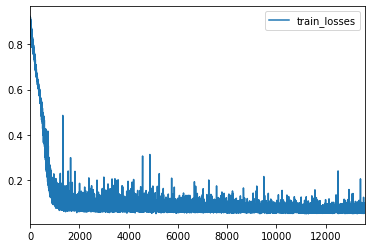

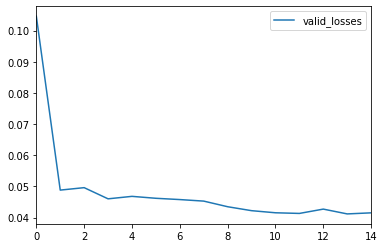

In [102]:
%%time
train_split_and_move(fold_info, 0)

In [ ]:
%%time
train_split_and_move(fold_info, 1)

In [ ]:
%%time
train_split_and_move(fold_info, 2)

In [ ]:
%%time
train_split_and_move(fold_info, 3)

In [ ]:
!mv *.pth models

In [ ]:
!ls